In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

In [2]:
X_train = pd.read_csv("./data/final_data/X_train.csv", encoding='utf-8')
X_test = pd.read_csv("./data/final_data/X_test.csv", encoding='utf-8')
y_train = pd.read_csv("./data/final_data/y_train.csv", encoding='utf-8')
y_test = pd.read_csv("./data/final_data/y_test.csv", encoding='utf-8')

In [3]:
xgb_model = GradientBoostingRegressor()

In [4]:
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], # Only relevant when loss='huber' or 'quantile'
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile']
}


In [5]:
random_search = RandomizedSearchCV(xgb_model, param_dist, n_iter=200, cv=5, verbose=3, n_jobs=-1, scoring="neg_mean_absolute_error")

In [6]:
random_search.fit(X_train.drop(columns=["ID", "season", "games_started_perc", "minutes_played", "PER"]), y_train.values.ravel())

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.2, 0.3, 0.4, 0.5],
                                        'loss': ['squared_error',
                                                 'absolute_error', 'huber',
                                                 'quantile'],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [7]:
results_random = pd.DataFrame(random_search.cv_results_)
results_random.sort_values(by="rank_test_score", inplace=True)

In [8]:
print(f"Best MAE from random search: {random_search.best_score_}")
print(f"Best params from random search: {random_search.best_params_}")

Best MAE from random search: -0.029730856181834315
Best params from random search: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 4, 'loss': 'huber', 'learning_rate': 0.02, 'alpha': 0.4}


In [9]:
model = GradientBoostingRegressor(subsample=0.8, n_estimators=300, min_samples_split=4, min_samples_leaf=3, max_features=None, max_depth=4, loss='huber', learning_rate=0.02, alpha=0.4)

In [10]:
model.fit(X_train.drop(columns=["ID", "season", "games_started_perc", "minutes_played", "PER"]), y_train.values.ravel())

GradientBoostingRegressor(alpha=0.4, learning_rate=0.02, loss='huber',
                          max_depth=4, min_samples_leaf=3, min_samples_split=4,
                          n_estimators=300, subsample=0.8)

In [14]:
importances = model.feature_importances_

In [15]:
y_pred = model.predict(X_test.drop(columns=["ID", "season", "games_started_perc", "minutes_played", "PER"]))

In [16]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [17]:
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 0.031541027965704876
Mean Squared Error: 0.0023931281123898097
R-squared: 0.63411961858579


In [18]:
# for residuales, convert df to series
y_test_series = y_test.squeeze()

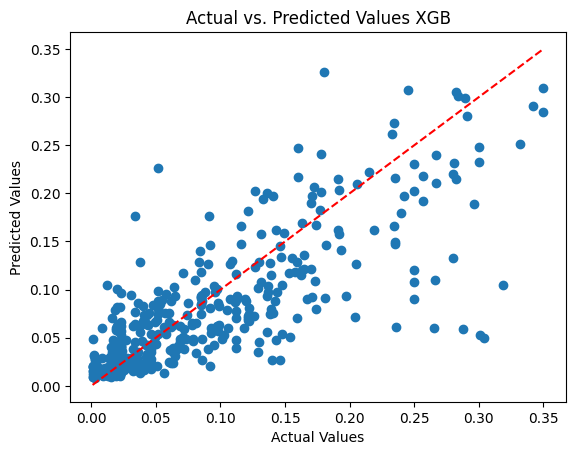

In [19]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values XGB')
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
plt.show()

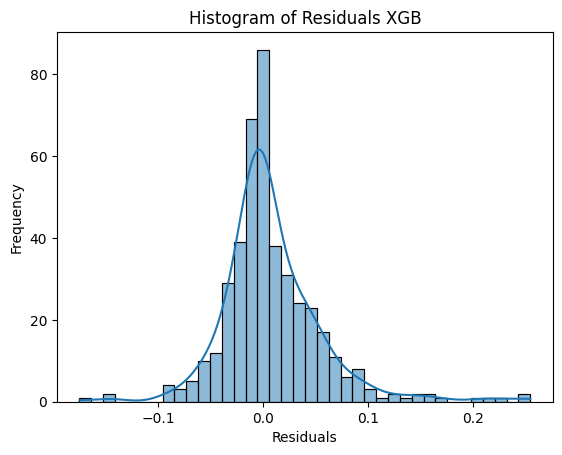

In [22]:
residuals = y_test_series - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals XGB')
plt.show()

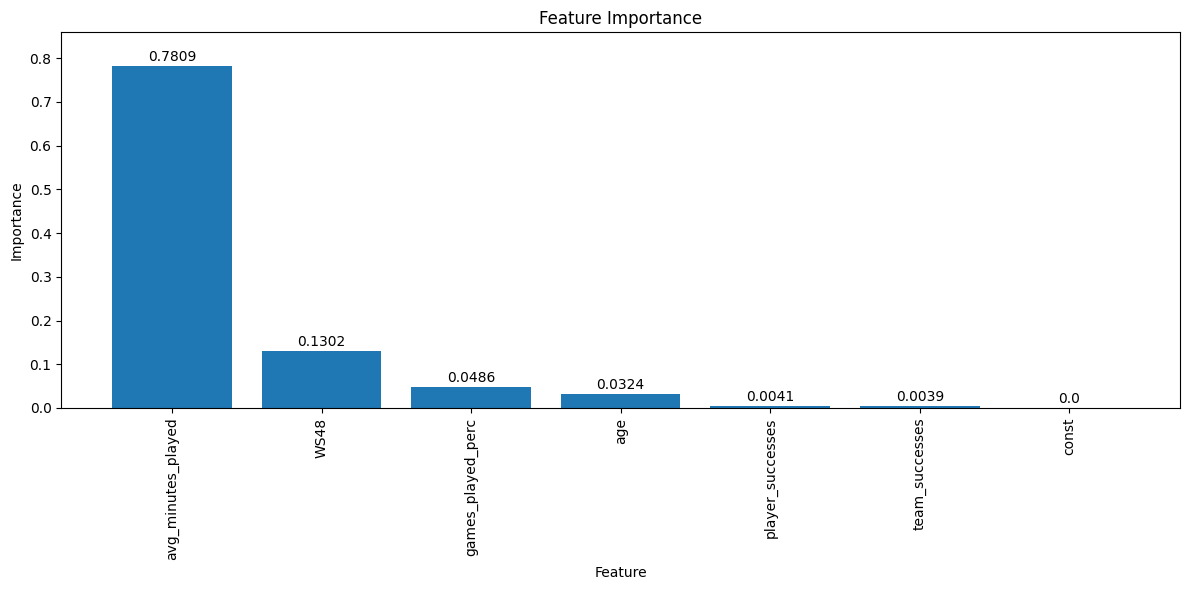

In [27]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

X_train_drop = X_train.drop(columns=["ID", "season", "games_started_perc", "minutes_played", "PER"])
# Rearrange feature names so they match the sorted feature importances
names = [X_train_drop.columns[i] for i in indices]

# Create a plot
plt.figure(figsize=(12, 6))

# Create bars
bars = plt.bar(range(len(importances)), importances[indices], align="center")

# Add feature names as x-axis labels
plt.xticks(range(len(importances)), names, rotation=90)

# Create plot title and axis titles
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")

# Adjust the y-axis limits: set the upper limit to 1.1 times the highest feature importance
plt.ylim(0, max(importances[indices]) * 1.1)

# Annotate bars with their values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom')

# Show plot
plt.tight_layout()  # Adjust layout for better visualization if necessary
plt.show()

In [29]:
compare_data = X_test.copy()
compare_data["actual_salary_cap_as_perc"] = y_test
compare_data["predicted_salary_cap_as_perc"] = y_pred
compare_data["difference"] = compare_data["predicted_salary_cap_as_perc"] - compare_data["actual_salary_cap_as_perc"]

In [35]:
len(compare_data[(compare_data.difference > 0.031541)].index)

112

In [36]:
len(compare_data[(compare_data.difference < -0.031541)].index)

144